# Poisson likelihood and Gamma prior

This is a simple model where our discrete data, $y$, is modelled as a Poisson RV with Gamma prior, which is a conjugate prior model.

$L(x) = p(y | x) = \mathcal{P}[y \mid x]$

and

$p(x) = \Gamma[x \mid k, \theta]$.

The analytic evidence for this model is,

$Z = p(y) = \int_\mathcal{X} L(x) p(x) \,\mathrm{d} x =  \mathcal{P}[y \mid 1] \frac{\Gamma[1 \mid k, \theta]}{\Gamma[1 \mid k', \theta']}$

The posterior is also a Gamma distribution,

$p(x \mid y) = \Gamma[x \mid k', \theta']$

where

$k' = k + \sum_i y_i$

and

$\theta' = \frac{\theta}{(\theta \sum_i y_i + 1)}$

In [1]:

import numpy as np
import pylab as plt
import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp

from jaxns import resample

tfpd = tfp.distributions

INFO[2023-06-15 15:21:49,106]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2023-06-15 15:21:49,107]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-06-15 15:21:49,107]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-06-15 15:21:49,108]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
INFO[2023-06-15 15:21:49,108]: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
WARNING[2023-06-15 15:21:49,109]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
# Generate data
np.random.seed(42)

num_samples = 10

true_k = 0.5
true_theta = 1.
_gamma = np.random.gamma(true_k, true_theta, size=num_samples)
print(f"Taking {num_samples} samples from a Poisson distribution as data.")
data = jnp.asarray(np.random.poisson(_gamma, size=num_samples))

Taking 10 samples from a Poisson distribution as data.


In [3]:

from jaxns import Prior, Model

# Build model
prior_k = 100.

# Note if prior_theta is chosen too large 32-bit will be insufficient
prior_theta = 0.1


def prior_model():
    lamda = yield Prior(
        tfpd.Gamma(concentration=prior_k, rate=1. / prior_theta),
        name='lamda')
    return lamda


def log_likelihood(lamda):
    """
    Poisson likelihood.
    """
    _log_prob = jnp.sum(tfpd.Poisson(rate=lamda).log_prob(data))
    return _log_prob


model = Model(prior_model=prior_model, log_likelihood=log_likelihood)

model.sanity_check(random.PRNGKey(0), S=100)

INFO[2023-06-15 15:21:52,348]: Sanity check...
INFO[2023-06-15 15:21:52,784]: Sanity check passed


In [4]:
# Evidence and posterior are analytic
def log_gamma_prob(lamda, k, theta):
    return tfpd.Gamma(concentration=k, rate=1. / theta).log_prob(lamda)
    # return (k-1) * jnp.log(gamma)  - gamma / theta - gammaln(k) - k * jnp.log(theta)


true_post_k = prior_k + jnp.sum(data)
true_post_theta = prior_theta / (num_samples * prior_theta + 1.)

true_post_mean_gamma = true_post_theta * true_post_k

true_logZ = log_likelihood(1.) + log_gamma_prob(1., prior_k, prior_theta) - log_gamma_prob(1., true_post_k,
                                                                                           true_post_theta)
print(f"True Evidence = {true_logZ}")
print(f"True posterior concentration (k) = {true_post_k}")
print(f"True posterior rate (1/theta) = {1. / true_post_theta}")
print(f"True posterior lamda = {true_post_mean_gamma}")


True Evidence = -69.31472778320312
True posterior concentration (k) = 100.0
True posterior rate (1/theta) = 20.0
True posterior lamda = 5.0


In [5]:
from jaxns import ExactNestedSampler, TerminationCondition

# Run the nested sampling
ns = ExactNestedSampler(model=model, num_live_points=100, max_samples=1e4)

term_reason, state = ns(random.PRNGKey(3452345), term_cond=TerminationCondition(live_evidence_frac=1e-4))
results = ns.to_results(state, termination_reason=term_reason)

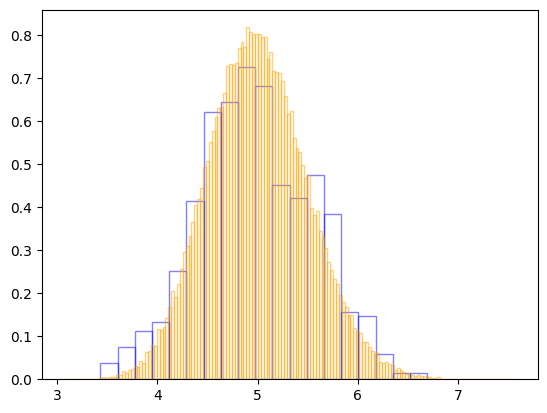

In [6]:
# Comparing samples to true posterior

samples = resample(random.PRNGKey(43083245), results.samples, results.log_dp_mean, S=int(results.ESS))

plt.hist(samples['lamda'], bins='auto', ec='blue', alpha=0.5, density=True, fc='none')

_gamma = np.random.gamma(true_post_k, true_post_theta, size=100000)

plt.hist(_gamma, bins='auto', ec='orange', alpha=0.5, density=True, fc='none')
plt.show()